In [29]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from marbleri.models import BaseConvNet
from marbleri.process import get_hwrf_filenames
from marbleri.nwp import HWRFStep, BestTrackNetCDF
from sklearn.metrics import mean_absolute_error
from glob import glob
from os.path import join, exists
import pandas as pd
from matplotlib.colors import LogNorm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import save_model
from marbleri.training import partition_storm_examples
from dask.distributed import LocalCluster, Client

%matplotlib inline


In [2]:
print(tf.__version__)

2.0.0


In [3]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.experimental.list_physical_devices())
except AttributeError:
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    K.set_session(tf.Session(config=tf_config))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [5]:
get_available_gpus()

['/device:GPU:0']

In [6]:
rank = 0
np.random.seed(34343)
best_track = pd.read_csv("/glade/scratch/dgagne/hfip/processed_data_dv_lossy/best_track_all.csv", index_col="Index")
print("original best track count", best_track.shape[0])
out_col = "dvmax_bt_12"
best_track = best_track.loc[np.abs(best_track[out_col]) < 1000, :].reset_index(drop=True)
print("filtered best track count", best_track.shape[0])
train_rank_indices, val_rank_indices = partition_storm_examples(best_track, 1,
                                                                0.2)

original best track count 51969
filtered best track count 48876


In [192]:
best_track.columns

Index(['DATE', 'STNAM', 'STNUM', 'BASIN', 'TIME', 'LON', 'LAT', 'VMAX', 'RMW',
       'MIN_SLP', 'SHR_MAG', 'SHR_HDG', 'STM_SPD', 'STM_HDG', 'SST', 'TPW',
       'LAND', 'TANG850', 'VORT850', 'DVRG200', 'RHLO', 'RHMD', 'RHHI',
       'CAPE1', 'CAPE2', 'CAPE3', 'LHTFL1', 'LHTFL2', 'LHTFL3', 'SHTFL1',
       'SHTFL2', 'SHTFL3', 'VMAXMPI', 'POTMPI', 'TGRD', 'IKE1', 'IKE2',
       'TCOND7001', 'TCOND7002', 'TCOND7003', 'TCONDALL1', 'TCONDALL2',
       'TCONDALL3', 'INST1', 'INST2', 'INST3', 'CP1', 'CP2', 'CP3',
       'TCONDSYM1', 'TCONDSYM2', 'TCONDSYM3', 'INERTSYM1', 'INERTSYM2',
       'INERTSYM3', 'COUPLSYM1', 'COUPLSYM2', 'COUPLSYM3', 'WALLA1', 'WALLA2',
       'WALLA3', 'WSYM1', 'WSYM2', 'WSYM3', 'USFC1', 'USFC2', 'USFC3',
       'USFCSYM1', 'USFCSYM2', 'USFCSYM3', 'vmax_bt_new', 'dvmax_bt_12',
       'dvmax_bt_24'],
      dtype='object')

In [7]:
hwrf_path = "/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/"
hwrf_files = get_hwrf_filenames(best_track, hwrf_path)

In [4]:
['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

In [23]:
input_var_levels = []
m_vars = ["THETA_E_L100", "U_RAD_L100", "V_TAN_L100"]
s_vars = ["TCOLC_E_L103"]
p_levs = [20000, 85000]
for m_var in m_vars:
    for p_lev in p_levs:
        input_var_levels.append((m_var, p_lev))
for s_var in s_vars:
    input_var_levels.append((s_var, None))

In [10]:
hwrf_exists = np.array([exists(hwrf_file) for hwrf_file in hwrf_files])

In [13]:
np.any(~hwrf_exists)

False

In [37]:
cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)

In [25]:
def load_data(hwrf_file_list, input_var_levels=None):
    data = []
    step_data = []
    for t, train_file in enumerate(hwrf_file_list):
        step = HWRFStep(train_file)
        for var in input_var_levels:
            step_data.append(step.get_variable(var[0], level=var[1]).values)
        step.close()
        data.append(np.stack(step_data, axis=-1))
    train_data = np.stack(data, axis=0)
    return train_data

In [43]:
hwrf_files[train_rank_indices[0]]

array(['/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest01l.2015050700.f015.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/hermine09l.2016090118.f105.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/irma11l.2017090712.f084.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/lee14l.2017091618.f018.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/dolores05e.2015071318.f087.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/guillermo09e.2015073112.f060.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/invest13e.2015082612.f054.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/fifteen15e.2017091400.f102.nc',
       '/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/tina21e.2016111418.f045.nc'],
      dtype='<U80')

In [47]:
slice_indices = np.linspace(0, hwrf_files[train_rank_indices[0]].size, 9).astype(int)
slice_indices

array([    0,  4936,  9872, 14809, 19745, 24681, 29618, 34554, 39491])

In [49]:
hwrf_subsets = [hwrf_files[train_rank_indices[0]][slice_index:slice_indices[s + 1]] for s, slice_index in enumerate(slice_indices[:-1])]

In [60]:
np.sum([hwrf_subsets[i].shape[0] for i in range(len(hwrf_subsets))])

39491

In [61]:
out = client.map(load_data, hwrf_subsets, input_var_levels=input_var_levels)

In [62]:
train_data = np.vstack(client.gather(out))

In [70]:
val_slice_indices = np.linspace(0, hwrf_files[val_rank_indices[0]].size, 9).astype(int)
hwrf_val_subsets = [hwrf_files[train_rank_indices[0]][slice_index:val_slice_indices[s + 1]] for s, slice_index in enumerate(val_slice_indices[:-1])]

In [71]:
val_out = client.map(load_data, hwrf_val_subsets, input_var_levels=input_var_levels)

In [72]:
val_data = np.vstack(client.gather(val_out))

In [69]:
norm_train_data = np.zeros(train_data.shape, dtype=np.float32)
train_scaling = np.zeros((train_data.shape[-1], 2), dtype=np.float32)
for c in range(norm_train_data.shape[-1]):
    train_scaling[c, 0] = np.nanmean(train_data[:, :, :, c])
    train_scaling[c, 1] = np.nanstd(train_data[:, :, :, c])
    norm_train_data[:, :, :, c] = (train_data[:, :, :, c] - train_scaling[c, 0]) / train_scaling[c, 1]
norm_train_data[np.isnan(train_data)] = 0

In [73]:
norm_val_data = np.zeros(val_data.shape, dtype=np.float32)
for c in range(norm_val_data.shape[-1]):
    norm_val_data[:, :, :, c] = (val_data[:, :, :, c] - train_scaling[c, 0]) / train_scaling[c, 1]
norm_val_data[np.isnan(val_data)] = 0

In [262]:
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input, Flatten, AveragePooling2D, MaxPool2D, LeakyReLU, Dropout, Add
from tensorflow.keras.layers import BatchNormalization, Concatenate, Layer, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, binary_crossentropy
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.regularizers import l2

class NormOut(Layer):
    def __init__(self, **kwargs):
        self.mean_dense = Dense(1, **kwargs)
        self.sd_dense = Dense(1, activation=K.exp, **kwargs)
        super(NormOut, self).__init__()

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        return Concatenate()([mean_x, sd_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], 2


class GaussianMixtureOut(Layer):
    def __init__(self, mixtures=2, **kwargs):
        self.mixtures = mixtures
        self.mean_dense = Dense(self.mixtures, activation="relu", **kwargs)
        self.sd_dense = Dense(self.mixtures, activation=K.exp, **kwargs)
        self.weight_dense = Dense(self.mixtures, activation="softmax", **kwargs)
        super(GaussianMixtureOut, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        weights_x = self.weight_dense(inputs)
        return Concatenate()([mean_x, sd_x, weights_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.mixtures * 3


def crps_norm(y_true, y_pred, cdf_points=np.arange(-200, 200.0, 1.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    y_pred_cdf = tfd.Normal(loc=y_pred[:, 0:1], scale=y_pred[:, 1:2]).cdf(cdf_points_tensor)
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)


def crps_mixture(y_true, y_pred, cdf_points=np.arange(0, 200.0, 5.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    num_mixtures = y_pred.shape[1] // 3
    weights = [y_pred[:, 2 * num_mixtures + i: 2 * num_mixtures + i + 1] for i in range(num_mixtures)]
    locs = [y_pred[:, i:i+1] for i in range(num_mixtures)]
    scales = [y_pred[:, num_mixtures + i: num_mixtures + i + 1] for i in range(num_mixtures)]
    y_pred_cdf = tf.add_n([weights[i] * tfd.Normal(loc=locs[i], scale=scales[i]).cdf(cdf_points_tensor)
                             for i in range(num_mixtures)])
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)

losses = {"mse": mean_squared_error,
          "mae": mean_absolute_error,
          "crps_norm": crps_norm,
          "crps_mixture": crps_mixture,
          "binary_crossentropy": binary_crossentropy}

class BaseConvNet(object):
    def __init__(self, min_filters=16, filter_growth_rate=2, filter_width=5, min_data_width=4, pooling_width=2,
                 hidden_activation="relu", output_type="linear",
                 pooling="mean", use_dropout=False, dropout_alpha=0.0, dense_neurons=64,
                 data_format="channels_first", optimizer="adam", loss="mse", leaky_alpha=0.1, metrics=None,
                 learning_rate=0.0001, batch_size=1024, epochs=10, verbose=0, l2_alpha=0, distributed=False):
        self.min_filters = min_filters
        self.filter_width = filter_width
        self.filter_growth_rate = filter_growth_rate
        self.pooling_width = pooling_width
        self.min_data_width = min_data_width
        self.hidden_activation = hidden_activation
        self.output_type = output_type
        self.use_dropout = use_dropout
        self.pooling = pooling
        self.dropout_alpha = dropout_alpha
        self.data_format = data_format
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.loss = loss
        self.dense_neurons = dense_neurons
        self.metrics = metrics
        self.leaky_alpha = leaky_alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.parallel_model = None
        self.l2_alpha = l2_alpha
        if l2_alpha > 0:
            self.use_l2 = True
        else:
            self.use_l2 = False
        self.verbose = verbose
        self.distributed = distributed

    def build_network(self, conv_input_shape, output_size):
        """
        Create a keras model with the hyperparameters specified in the constructor.

        Args:
            conv_input_shape (tuple of shape [variable, y, x]): The shape of the input data
            output_size: Number of neurons in output layer.
        """
        print("Conv input shape", conv_input_shape)
        if self.use_l2:
            reg = l2(self.l2_alpha)
        else:
            reg = None
        conv_input_layer = Input(shape=conv_input_shape, name="conv_input")
        num_conv_layers = int(np.round((np.log(conv_input_shape[1]) - np.log(self.min_data_width))
                                       / np.log(self.pooling_width)))
        print(num_conv_layers)
        num_filters = self.min_filters
        scn_model = conv_input_layer
        for c in range(num_conv_layers):
            scn_model = Conv2D(num_filters, (self.filter_width, self.filter_width),
                               data_format=self.data_format, kernel_regularizer=reg,
                               padding="same", name="conv_{0:02d}".format(c))(scn_model)
            if self.hidden_activation == "leaky":
                scn_model = LeakyReLU(self.leaky_alpha, name="hidden_activation_{0:02d}".format(c))(scn_model)
            else:
                scn_model = Activation(self.hidden_activation, name="hidden_activation_{0:02d}".format(c))(scn_model)
            if self.use_dropout:
                scn_model = SpatialDropout2D(rate=self.dropout_alpha)(scn_model)
            num_filters = int(num_filters * self.filter_growth_rate)
            if self.pooling.lower() == "max":
                scn_model = MaxPool2D(pool_size=(self.pooling_width, self.pooling_width),
                                      data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
            else:
                scn_model = AveragePooling2D(pool_size=(self.pooling_width, self.pooling_width),
                                             data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
        scn_model = Flatten(name="flatten")(scn_model)

        if self.output_type == "linear":
            scn_model = Dense(output_size, name="dense_output")(scn_model)
            scn_model = Activation("linear", name="activation_output")(scn_model)
        elif self.output_type == "gaussian":
            scn_model = NormOut()(scn_model)
        elif "mixture" in self.output_type:
            num_mixtures = int(self.output_type.split("_")[1])
            scn_model = GaussianMixtureOut(mixtures=num_mixtures)(scn_model)
        self.model = Model(conv_input_layer, scn_model)
        print(self.model.summary())

    def compile_model(self):
        """
        Compile the model in tensorflow with the right optimizer and loss function.
        """
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        if self.distributed:
            opt = DistributedOptimizer(opt)
        self.model.compile(opt, losses[self.loss], metrics=self.metrics)

    def compile_parallel_model(self, num_gpus):
        self.parallel_model = multi_gpu_model(self.model, num_gpus)
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        self.parallel_model.compile(opt, losses[self.loss], metrics=self.metrics)

    @staticmethod
    def get_data_shapes(x, y):
        """
        Extract the input and output data shapes in order to construct the neural network.
        """
        if len(x.shape) != 4:
            raise ValueError("Input data does not have dimensions (examples, y, x, predictor)")
        if len(y.shape) == 1:
            output_size = 1
        else:
            output_size = y.shape[1]
        return x.shape[1:], output_size

    @staticmethod
    def get_generator_data_shapes(data_gen):
        inputs, outputs = data_gen.__getitem__(0)
        if len(outputs.shape) == 1:
            output_size = 1
        else:
            output_size = outputs.shape[1]
        return inputs.shape[1:], output_size

    def fit(self, x, y, val_x=None, val_y=None, build=True, **kwargs):
        """
        Train the neural network.
        """
        if build:
            x_conv_shape, y_size = self.get_data_shapes(x, y)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        if val_x is None:
            val_data = None
        else:
            val_data = (val_x, val_y)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose,
                       validation_data=val_data, **kwargs)

    def fit_generator(self, generator, build=True, validation_generator=None, **kwargs):
        if build:
            x_conv_shape, y_size = self.get_generator_data_shapes(generator)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        self.model.fit_generator(generator, epochs=self.epochs, verbose=self.verbose,
                                 validation_data=validation_generator, **kwargs)

    def predict(self, x, y):
        return self.model.predict(x, y, batch_size=self.batch_size)

In [260]:
dv_train = best_track[out_col].values[train_rank_indices[0]]
np.unique(dv_train)

array([-130. , -107.5, -102.5,  -85. ,  -75. ,  -55. ,  -52.5,  -50. ,
        -45. ,  -40. ,  -37.5,  -35. ,  -32.5,  -30. ,  -27.5,  -25. ,
        -22.5,  -20. ,  -17.5,  -15. ,  -12.5,  -10. ,   -7.5,   -5. ,
         -2.5,    0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,
         17.5,   20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,
         37.5,   40. ,   45. ,   50. ,   60. ,   62.5,   65. ])

In [264]:
bcn = BaseConvNet(min_filters=16, filter_growth_rate=1.5, filter_width=5, pooling="max", data_format="channels_last",
             verbose=1, loss="mae", batch_size=1024, epochs=10, use_dropout=False, dropout_alpha=0.1, l2_alpha=0, min_data_width=7, learning_rate=0.0001)
bcn.fit(norm_train_data, best_track["b"])

Conv input shape (125, 126, 7)
4
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      [(None, 125, 126, 7)]     0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 125, 126, 16)      2816      
_________________________________________________________________
hidden_activation_00 (Activa (None, 125, 126, 16)      0         
_________________________________________________________________
pooling_00 (MaxPooling2D)    (None, 62, 63, 16)        0         
_________________________________________________________________
conv_01 (Conv2D)             (None, 62, 63, 24)        9624      
_________________________________________________________________
hidden_activation_01 (Activa (None, 62, 63, 24)        0         
_________________________________________________________________
pooling_01 (MaxPooling2D)

In [96]:
save_model(bcn.model, "hwrf_base_cnn.h5", save_format="h5")

In [265]:
preds = bcn.model.predict(norm_val_data, batch_size=2048).ravel()

In [266]:
train_preds = bcn.model.predict(norm_train_data, batch_size=2048).ravel()

In [268]:
from hagelslag.evaluation.ProbabilityMetrics import DistributedReliability

In [269]:
dr = DistributedReliability()

In [270]:
dr.update(preds, np.where(best_track[out_col].values[val_rank_indices[0]] > 15, 1, 0))

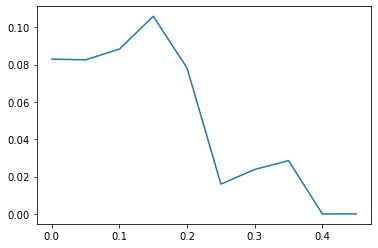

In [275]:
rel_curve = dr.reliability_curve()
plt.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"])

(array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 

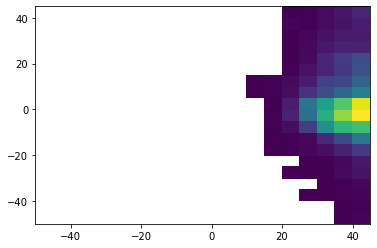

In [282]:
plt.hist2d(best_track["VMAX"], best_track["dvmax_bt_24"], bins=np.arange(-50, 50, 5), cmin=1)

In [84]:
preds.shape

(9385, 1)

In [48]:
best_track[out_col].values[val_rank_indices[0]].shape

(9385,)

In [255]:
import sklearn.metrics as skm
skm.mean_absolute_error(best_track[out_col].values[val_rank_indices[0]], preds)

8.468555224093944

In [256]:
skm.mean_absolute_error(best_track[out_col].values[train_rank_indices[0]], train_preds)

6.301808923420555

(array([  36.,   49.,   67.,  200.,  162.,  462.,  995., 2386., 2631.,
         937.,  727.,  308.,  230.,   95.,   43.,   31.]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25,  30,  35,  40]),
 <a list of 16 Patch objects>)

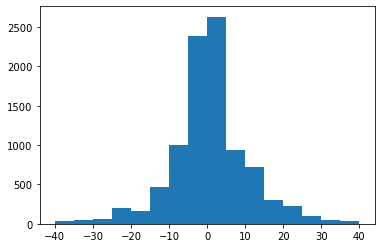

In [228]:
dvs = best_track[out_col].values[val_rank_indices[0]]
plt.hist(dvs, bins=np.arange(-40, 45, 5))

In [251]:
np.mean(np.abs(best_track[out_col].values[train_rank_indices[0]].mean() - best_track[out_col].values[val_rank_indices[0]]))

7.326690312165837

In [133]:
fhours = best_track.loc[val_rank_indices[0], "TIME"].values
dvs = best_track[out_col].values[val_rank_indices[0]]
unique_fhours = np.unique(fhours)
maes = np.zeros(unique_fhours.shape)
for f, fh in enumerate(unique_fhours):
    idxs = fhours == fh
    print(fh, np.count_nonzero(idxs))
    maes[f] = skm.mean_absolute_error(dvs[idxs], preds.ravel()[idxs])

3 339
6 357
9 346
12 355
15 345
18 340
21 327
24 320
27 308
30 305
33 291
36 294
39 268
42 276
45 269
48 258
51 253
54 253
57 242
60 242
63 227
66 221
69 221
72 216
75 205
78 207
81 197
84 200
87 191
90 190
93 179
96 170
99 165
102 166
105 161
108 170
111 157
114 154


In [134]:
fhours = best_track.loc[train_rank_indices[0], "TIME"].values
dvs = best_track[out_col].values[train_rank_indices[0]]
unique_fhours = np.unique(fhours)
train_maes = np.zeros(unique_fhours.shape)
for f, fh in enumerate(unique_fhours):
    idxs = fhours == fh
    print(fh, np.count_nonzero(idxs))
    train_maes[f] = skm.mean_absolute_error(dvs[idxs], train_preds.ravel()[idxs])

3 1293
6 1398
9 1375
12 1409
15 1384
18 1397
21 1353
24 1348
27 1288
30 1282
33 1245
36 1223
39 1174
42 1174
45 1153
48 1145
51 1095
54 1104
57 1070
60 1041
63 996
66 1009
69 954
72 936
75 888
78 889
81 839
84 841
87 795
90 777
93 743
96 747
99 711
102 697
105 708
108 698
111 664
114 648


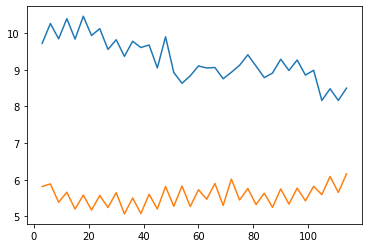

In [135]:
plt.plot(unique_fhours, maes)
plt.plot(unique_fhours, train_maes)

In [70]:
np.intersect1d(bt_train_indices, bt_val_indices)

array([], dtype=int64)

In [81]:
plt.pcolormesh(norm_train_data[:, :, :, 7].mean(axis=0))

IndexError: index 7 is out of bounds for axis 3 with size 7

In [220]:
np.corrcoef(best_track[out_col].values[val_rank_indices[0]], preds.ravel())

array([[1.        , 0.05835875],
       [0.05835875, 1.        ]])

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


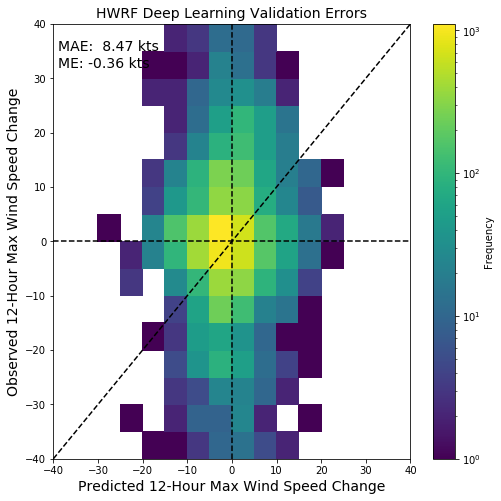

In [257]:
mae = mean_absolute_error(best_track[out_col].values[val_rank_indices[0]], preds.ravel())
me = np.mean(best_track[out_col].values[val_rank_indices[0]] - preds.ravel())
dvs = best_track[out_col].values[val_rank_indices[0]]

plt.figure(figsize=(8, 8))
plt.hist2d(preds.ravel(), dvs, bins=np.arange(-40, 45, 5), cmin=1, norm=LogNorm())
diag = np.arange(-40, 45, 5)
plt.plot(diag, diag, 'k--')
plt.plot(np.zeros(diag.shape), diag, 'k--')
plt.plot(diag, np.zeros(diag.shape), 'k--')
plt.text(-39, 35, f"MAE: {mae: 0.2f} kts", fontsize=14)
plt.text(-39, 32, f"ME: {me: 0.2f} kts", fontsize=14)
plt.xlabel("Predicted 12-Hour Max Wind Speed Change", fontsize=14)
plt.ylabel("Observed 12-Hour Max Wind Speed Change", fontsize=14)
plt.colorbar(label="Frequency")
plt.title("HWRF Deep Learning Validation Errors", fontsize=14)
plt.savefig("hwrf_cnn_error_hist.png", dpi=200, bbox_inches="tight")

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


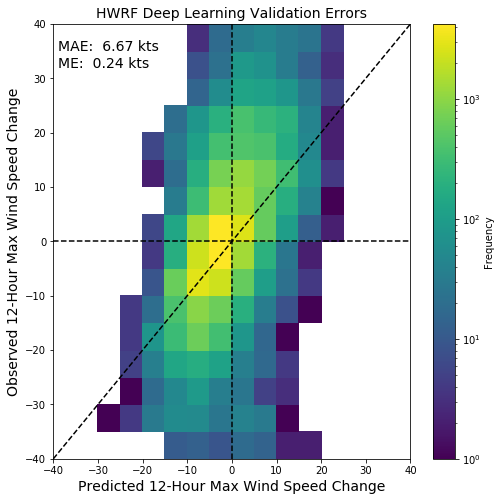

In [222]:
dvs = best_track[out_col].values[train_rank_indices[0]]
mae = skm.mean_absolute_error(dvs, train_preds.ravel())
me = np.mean(dvs - train_preds.ravel())

plt.figure(figsize=(8, 8))
plt.hist2d(train_preds.ravel(), dvs, bins=np.arange(-40, 45, 5), cmin=1, norm=LogNorm())
diag = np.arange(-40, 45, 5)
plt.plot(diag, diag, 'k--')
plt.plot(np.zeros(diag.shape), diag, 'k--')
plt.plot(diag, np.zeros(diag.shape), 'k--')
plt.text(-39, 35, f"MAE: {mae: 0.2f} kts", fontsize=14)
plt.text(-39, 32, f"ME: {me: 0.2f} kts", fontsize=14)
plt.xlabel("Predicted 12-Hour Max Wind Speed Change", fontsize=14)
plt.ylabel("Observed 12-Hour Max Wind Speed Change", fontsize=14)
plt.colorbar(label="Frequency")
plt.title("HWRF Deep Learning Validation Errors", fontsize=14)
plt.savefig("hwrf_cnn_error_hist.png", dpi=200, bbox_inches="tight")

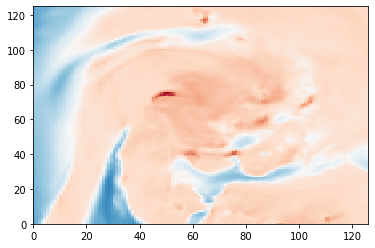

In [208]:
plt.pcolormesh(norm_train_data[19831, :, :, 1], vmin=-3, vmax=3, cmap="RdBu_r")

In [183]:
np.where(best_track["STNAM"] == 'maria')

(array([19823, 19824, 19825, ..., 21402, 21403, 21404]),)

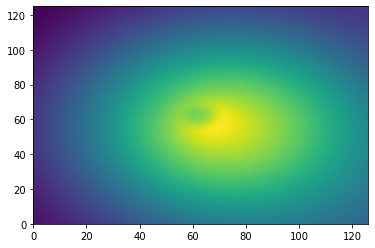

In [160]:
mean_field = np.expand_dims(np.nanmean(train_data[:, :, :, 0], axis=0), 0)
plt.pcolormesh(mean_field[0])

In [148]:
out = (np.zeros((5, 30, 30)) - np.random.normal(size=(1, 30, 30)))

In [150]:
out[:, 0, 0]

array([-1.0766212, -1.0766212, -1.0766212, -1.0766212, -1.0766212])

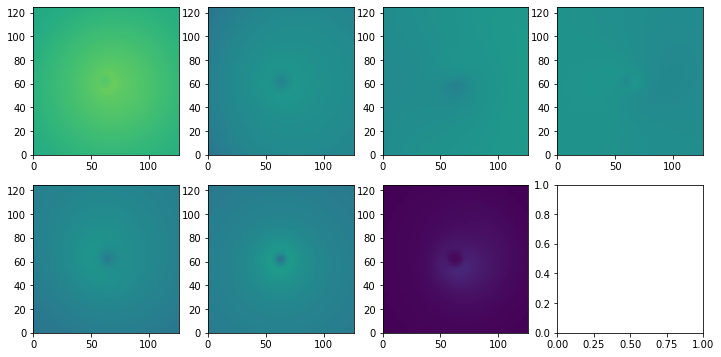

In [199]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for a, ax in enumerate(axes.ravel()):
    if a < train_data.shape[-1]:
        ax.pcolormesh(np.nanmean(train_data[best_track.loc[train_rank_indices[0], out_col] > 10, :, :, a], axis=0),
                      vmin=np.nanmin(train_data[:, :, :, a]), vmax=np.nanmax(train_data[:, :, :, a]))

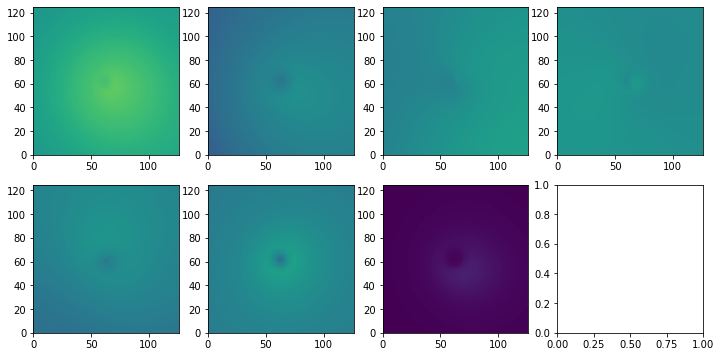

In [200]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for a, ax in enumerate(axes.ravel()):
    if a < train_data.shape[-1]:
        ax.pcolormesh(np.nanmean(train_data[best_track.loc[train_rank_indices[0], out_col] < 0, :, :, a], axis=0),
                     vmin=np.nanmin(train_data[:, :, :, a]), vmax=np.nanmax(train_data[:, :, :, a]))

In [96]:
from sklearn.metrics import confusion_matrix

In [100]:
class ContingencyTable(object):
    """
    Initializes a binary contingency table and generates many skill scores.

    Args:
        a: true positives
        b: false positives
        c: false negatives
        d: true negatives

    Attributes:
        table (numpy.ndarray): contingency table
        N: total number of items in table

    """
    def __init__(self, a, b, c, d):
        self.table = np.array([[a, b], [c, d]], dtype=float)
        self.N = self.table.sum()

    def update(self, a, b, c, d):
        """
        Update contingency table with new values without creating a new object.
        """
        self.table.ravel()[:] = [a, b, c, d]
        self.N = self.table.sum()

    def __add__(self, other):
        """
        Add two contingency tables together and return a combined one.

        Args:
            other: Another contingency table

        Returns:
            Sum of contingency tables
        """
        sum_ct = ContingencyTable(*(self.table + other.table).tolist())
        return sum_ct

    def pod(self):
        """
        Probability of Detection (POD) or Hit Rate.
        Formula:  a/(a+c)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[1, 0])

    def foh(self):
        """
        Frequency of Hits (FOH) or Success Ratio.
        Formula:  a/(a+b)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1])

    def far(self):
        """
        False Alarm Ratio (FAR).
        Formula:  b/(a+b)
        """
        return self.table[0, 1] / (self.table[0, 0] + self.table[0, 1])

    def pofd(self):
        """
        Probability of False Detection (POFD).
        b/(b+d)
        """
        return self.table[0, 1] / (self.table[0, 1] + self.table[1, 1])

    def fom(self):
        """
        Frequency of Misses (FOM).
        Formula:  c/(a+c)."""
        return self.table[1, 0] / (self.table[0, 0] + self.table[1, 0])

    def dfr(self):
        """Returns Detection Failure Ratio (DFR).
           Formula:  c/(c+d)"""
        return self.table[1, 0] / (self.table[1, 0] + self.table[1, 1])

    def pon(self):
        """Returns Probability of Null (PON).
           Formula:  d/(b+d)"""
        return self.table[1, 1] / (self.table[0, 1] + self.table[1, 1])

    def focn(self):
        """Returns Frequency of Correct Null (FOCN).
           Formula:  d/(c+d)"""
        return self.table[1, 1] / (self.table[1, 0] + self.table[1, 1])

    def bias(self):
        """
        Frequency Bias.
        Formula:  (a+b)/(a+c)"""
        return (self.table[0, 0] + self.table[0, 1]) / (self.table[0, 0] + self.table[1, 0])

    def accuracy(self):
        """Finley's measure, fraction correct, accuracy (a+d)/N"""
        return (self.table[0, 0] + self.table[1, 1]) / self.N

    def csi(self):
        """Gilbert's Score or Threat Score or Critical Success Index a/(a+b+c)"""
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0])

    def ets(self):
        """Equitable Threat Score, Gilbert Skill Score, v, (a - R)/(a + b + c - R), R=(a+b)(a+c)/N"""
        r = (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 0] + self.table[1, 0]) / self.N
        return (self.table[0, 0] - r) / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0] - r)

    def hss(self):
        """Doolittle (Heidke) Skill Score.  2(ad-bc)/((a+b)(b+d) + (a+c)(c+d))"""
        return 2 * (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / (
            (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 1] + self.table[1, 1]) +
            (self.table[0, 0] + self.table[1, 0]) * (self.table[1, 0] + self.table[1, 1]))

    def pss(self):
        """Peirce (Hansen-Kuipers, True) Skill Score (ad - bc)/((a+c)(b+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[1, 0]) * (self.table[0, 1] + self.table[1, 1]))

    def css(self):
        """Clayton Skill Score (ad - bc)/((a+b)(c+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[0, 1]) * (self.table[1, 0] + self.table[1, 1]))

    def __str__(self):
        table_string = '\tEvent\n\tYes\tNo\nYes\t%d\t%d\nNo\t%d\t%d\n' % (
            self.table[0, 0], self.table[0, 1], self.table[1, 0], self.table[1, 1])
        return table_string


In [102]:
cm = confusion_matrix(np.where(dvs > 0, 1, 0), np.where(preds.ravel() > 0, 1, 0))
ct = ContingencyTable(*cm.T.ravel().tolist())

In [106]:
dv_bin = np.where(dvs > 0, 1, 0) 
preds_bin = np.where(preds.ravel() > 0, 1, 0)
tp = np.count_nonzero((preds_bin == 1) & (dv_bin == 1))
fp = np.count_nonzero((preds_bin == 1) & (dv_bin == 0))
fn = np.count_nonzero((preds_bin == 0) & (dv_bin == 1))
tn = np.count_nonzero((preds_bin == 0) & (dv_bin == 0))

In [107]:
ct2 = ContingencyTable(tp, fp, fn, tn)

In [109]:
print(ct2)

	Event
	Yes	No
Yes	1706	2049
No	996	4634



In [116]:
ct2.pofd()

0.30659883285949424